In [ ]:
import os
from google.colab import drive

#drive.mount('/content/drive')

if 'drive' in os.listdir():
  directory = 'drive/MyDrive/UrbanSound/'
else:
  directory = ''

# Download and settings

In [ ]:
!wget -c https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2021-11-04 14:41:42--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  3.75MB/s    in 13m 12s 

2021-11-04 14:55:09 (7.26 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
!tar -xf UrbanSound8K.tar.gz

In [ ]:
!rm UrbanSound8K.tar.gz

In [ ]:
!pip install librosa

# Preprocessing

In [ ]:
#Just some metadata EDA
import pandas as pd

metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.tail()

,slice_file_name,fsID,start,end,salience,fold,classID,class
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn
8731,99812-1-6-0.wav,99812,332.289233,334.821332,2,7,1,car_horn


In [ ]:
metadata['class'].isna().any()

False

In [ ]:
metadata['slice_file_name'].isna().any()

False

In [ ]:
metadata.set_index('slice_file_name',inplace=True)

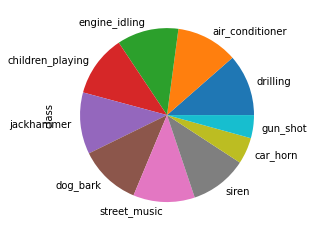

In [ ]:
import matplotlib.pyplot as plt

metadata['class'].value_counts().plot.pie()
plt.savefig('class-pie.pdf',bbox_inches='tight')
plt.show()

In [ ]:
sample_rate = 44100

In [ ]:
from os import listdir
import librosa

raw_sounds = []

for fold in range(1,11):
  path = f'UrbanSound8K/audio/fold{fold}/'
  for file in listdir(path):
    if "wav" in file:
      file_path = path + file
      sound_file, sr = librosa.load(file_path, sr = sample_rate) #load raw sound from sound files
      #print((file,sound_file,train_labels.loc[file]['classID']))
      row = metadata.loc[file]
      raw_sounds.append((file,sound_file,row['fold'],row['classID']))

In [ ]:
#SOUND FEATURE EXTRACTION
import numpy as np

hop_length = 256
frame_length = 512

features = []

for name,sound,fold,classid in raw_sounds:
  mfcc_coefficients = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=20).T,axis=0)
  stft = np.abs(librosa.stft(sound))
  chromas = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  zcr = np.mean(librosa.feature.zero_crossing_rate(sound,hop_length=hop_length,frame_length=frame_length))
  rms = librosa.feature.rms(sound, frame_length=frame_length, hop_length=hop_length, center=True)[0]
  rms_mean = np.mean(rms)
  rms_std = np.std(rms)
  rms_min = np.min(rms)
  rms_max = np.max(rms)
  features.append(np.hstack(([name],mfcc_coefficients,chromas,[zcr],[rms_mean,rms_std,rms_min,rms_max],[fold,classid])))

dfsound = pd.DataFrame(features, columns= ['slice_file_name'] \
                          + [f'mfcc_{i}' for i in range(len(mfcc_coefficients))] \
                          + [f'chroma_{i}' for i in range(len(chromas))] \
                          + ['zcr'] \
                          + ['rms_mean','rms_std','rms_min','rms_max'] + ['fold','classID'])

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
import pandas as pd
#dfsound contain slice_file_name, sound features, classID
dfsound.to_csv('urbansound_features.csv',index=False)
dfsound = pd.read_csv(directory+'urbansound_features.csv')

In [ ]:
dfsound.tail()

,slice_file_name,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,zcr,rms_mean,rms_std,rms_min,rms_max,fold,classID
8727,187110-2-0-6.wav,-300.81100,158.49199,-18.902058,11.490282,1.570917,10.287566,-4.005373,16.850101,4.004201,-1.516814,16.985640,5.337189,4.673947,0.973352,2.084913,3.423596,3.454432,-0.026633,-4.206310,1.568927,0.693632,0.692967,0.628879,0.609881,0.604386,0.570776,0.620230,0.677157,0.688122,0.603646,0.573767,0.626389,0.041831,0.039451,0.047655,0.008560,0.271989,10,2
8728,93567-8-0-6.wav,-210.20580,154.85762,-42.859417,12.426995,-19.213202,27.696434,-6.042531,26.984976,-4.129332,3.041716,-10.437231,16.336487,-1.056491,10.632118,1.414961,4.804009,-4.335826,3.472015,2.955493,1.852518,0.557810,0.581782,0.633965,0.704122,0.715808,0.727669,0.721813,0.704126,0.597280,0.567317,0.550955,0.552041,0.062667,0.049224,0.013076,0.024201,0.089276,10,8
8729,197554-2-0-60.wav,-436.97977,103.38572,-14.248773,2.543022,21.709919,10.179307,5.852466,27.069118,-0.697216,5.383002,15.369638,2.918409,6.180661,9.854775,2.880533,8.021476,8.602237,5.673036,3.322946,4.911674,0.779615,0.782908,0.776604,0.759137,0.739891,0.700484,0.673227,0.694166,0.715213,0.738371,0.758307,0.757505,0.062978,0.005291,0.002096,0.001536,0.013561,10,2
8730,72220-3-2-2.wav,-250.17790,114.78223,-39.544407,12.070447,-14.811690,-5.192843,-5.624414,-7.866743,-7.333050,-0.259648,-2.761649,3.214566,0.711630,1.297854,-5.003801,7.124520,1.752413,3.930275,-3.648508,-0.043226,0.775904,0.796006,0.710595,0.666769,0.682506,0.682720,0.701140,0.718242,0.761691,0.738982,0.703861,0.682276,0.091335,0.025767,0.019706,0.007150,0.120275,10,3
8731,129750-2-0-48.wav,-414.79266,162.81080,-8.554105,6.857782,-26.076551,4.422916,-13.406621,5.496144,2.516612,6.050804,-2.003603,4.341940,0.025889,1.757121,1.846528,3.048265,0.188334,5.327581,-0.267795,2.065346,0.757145,0.731353,0.698111,0.679758,0.683319,0.701962,0.727054,0.739181,0.747081,0.738578,0.741566,0.758928,0.042756,0.007260,0.003671,0.001879,0.024600,10,2


In [ ]:
#Train the model on folds: 1, 2, 3, 4, 6, and test it on folds: 5, 7, 8, 9, 10

train_folds = [1,2,3,4,6]
test_folds = [5,7,8,9,10]

In [ ]:
#SPECTOGRAM CONSTRUCTION
import os
import math
import librosa
import matplotlib.pyplot as plt

cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
count = 0
sample_rate = 44100

for fold in range(1,11):
  path = f'UrbanSound8K/audio/fold{fold}/'
  for file in os.listdir(path):
    if "wav" in file:
        file_path = path + file
        y, sr = librosa.load(file_path, sr = sample_rate)
        #print(y.shape)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');

        try:
          os.mkdir(f'UrbanSound8K/img_data/')
        except FileExistsError:
          pass
        try:
          os.mkdir(f'UrbanSound8K/img_data/fold{fold}')
        except FileExistsError:
          pass
        
        plt.savefig(f'UrbanSound8K/img_data/fold{fold}/{file[:-4]}.png',transparent=True, pad_inches=0.0)
        plt.clf()

        count += 1
        if count % 1000 == 0:
          print("Processed ", count, " files")

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Processed  1000  files
Processed  2000  files
Processed  3000  files
Processed  4000  files
Processed  5000  files
Processed  6000  files
Processed  7000  files
Processed  8000  files


<Figure size 576x576 with 0 Axes>

In [ ]:
#NORMALIZATION
from sklearn.preprocessing import StandardScaler

train = dfsound[dfsound['fold'].isin(train_folds)]
test = dfsound[dfsound['fold'].isin(test_folds)]

data_train = train.drop(['slice_file_name','fold','classID'],axis=1)
data_test = test.drop(['slice_file_name','fold','classID'],axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(data_train)
X_test = scaler.fit_transform(data_test)
y_train = train['classID']
y_test = test['classID']

In [ ]:
#TRAIN TEST SPLIT
test_per_fold = [test[test['fold']==f] for f in test_folds]
data_test_per_fold = list(map(lambda df: df.drop(['slice_file_name','fold','classID'],axis=1),test_per_fold))
X_test_per_fold = list(map(lambda data: scaler.fit_transform(data),data_test_per_fold))
y_test_per_fold = list(map(lambda df: df['classID'],test_per_fold))

In [ ]:
import numpy as np

validation_data = (X_test,y_test.values)

# Audio Player utility

In [ ]:
"""
import IPython.display as ipd
numTrack = 0 #number of track in dfsound dataset
nameTrack = dfsound['slice_file_name'][numTrack]
fold = dfsound[dfsound['slice_file_name']==nameTrack]['fold'].values[0]
fpath = f'UrbanSound8K/audio/fold{fold}/{nameTrack}'
ipd.Audio(fpath)
"""

ValueError: ignored

# Classification

In [ ]:
#Some imports and plot settings
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np

import os, re, math, json, shutil, pprint
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from google.colab import output
from IPython.display import clear_output

print("Tensorflow version " + tf.__version__)

np.set_printoptions(precision=3, threshold=11)

# Matplotlib config
plt.style.use('seaborn')
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__),
                                   "mpl-data/fonts/ttf")

Tensorflow version 2.7.0


## FFNN

In [ ]:
num_class = len(dfsound['classID'].unique())

In [ ]:
from keras.models import Sequential
from keras import layers

NUM_EPOCH = 100
BATCH_SIZE = 128
SAMPLE_SIZE = len(dfsound)

In [ ]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

### Zero hidden-layer

In [ ]:
history_ffnn = []
ffnn_labels = ['0hidden','1-hidden','2-hidden','3-hidden']

In [ ]:
ffnn_0hidden = Sequential()
ffnn_0hidden.add(layers.Input(shape=(X_train.shape[1],)))
ffnn_0hidden.add(layers.Dense(num_class, activation='softmax'))
ffnn_0hidden.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_0hidden.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                380       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ffnn_0hidden.fit(X_train,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=1,
                    callbacks = [early_stopping]
                    )
history_ffnn.append(history)       

Epoch 1/100
36/36 [==============================] - 0s 6ms/step - loss: 2.6245 - accuracy: 0.1525 - val_loss: 2.7386 - val_accuracy: 0.1250
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 2.3163 - accuracy: 0.2287 - val_loss: 2.4758 - val_accuracy: 0.1484
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 2.1121 - accuracy: 0.2874 - val_loss: 2.3037 - val_accuracy: 0.1562
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 1.9675 - accuracy: 0.3303 - val_loss: 2.1856 - val_accuracy: 0.1875
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 1.8611 - accuracy: 0.3643 - val_loss: 2.1027 - val_accuracy: 0.1875
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 1.7776 - accuracy: 0.3910 - val_loss: 2.0390 - val_accuracy: 0.2344
Epoch 7/100
36/36 [==============================] - 0s 4ms/step - loss: 1.7101 - accuracy: 0.4161 - val_loss: 1.9877 - val_accuracy: 0.2969
Epoch 8/100
3

In [ ]:
ITOFOLD = {i:str(tf) for i,tf in zip(range(0,len(test_folds)),test_folds)}

In [ ]:
def evaluate_on_test_folds(model,X_test_per_fold,y_test_per_fold):
  """
    Given the test folds returns the distribution of the accuracies along them.
  """
  accuracies = []
  for X_test,y_test in zip(X_test_per_fold,y_test_per_fold):
    _,acc = model.evaluate(X_test,y_test, batch_size=BATCH_SIZE)
    accuracies.append(acc)
  return accuracies

7/7 [==============================] - 0s 3ms/step - loss: 1.4229 - accuracy: 0.5233


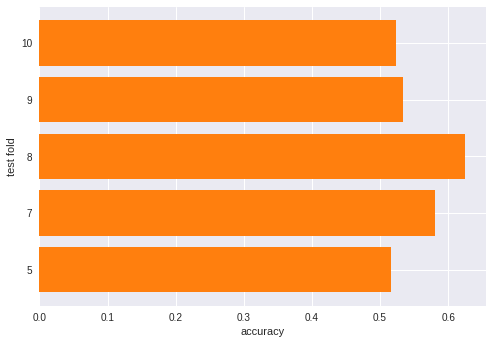

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_0hidden,X_test_per_fold,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnn_0hidden_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.5555317163467407
Std accuracy: 0.04085035995547616


### One hidden-layer

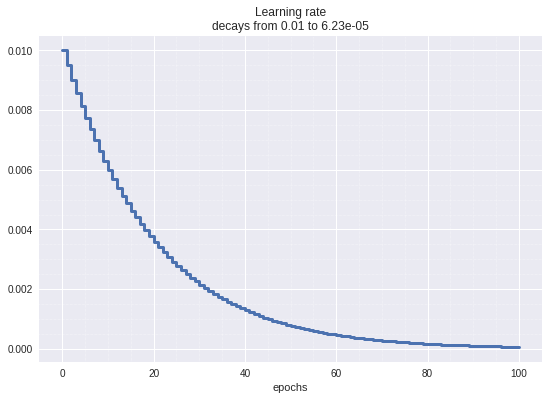

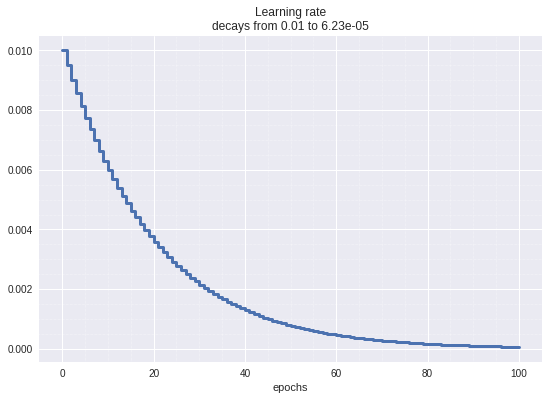

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.95, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  plt.savefig('lr-decay.pdf',bbox_inches='tight')
  display(fig)

plot_learning_rate(lr_decay, NUM_EPOCH)


In [ ]:
#One hidden-layer

ffnn_1hidden = Sequential()
ffnn_1hidden.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
ffnn_1hidden.add(layers.Dropout(0.25))
ffnn_1hidden.add(layers.Dense(num_class, activation='softmax'))
ffnn_1hidden.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_1hidden.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                1216      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 1,546
Trainable params: 1,546
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ffnn_1hidden.fit(X_train,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=1,
                    callbacks=[lr_decay_callback,early_stopping])

history_ffnn.append(history)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 8ms/step - loss: 1.6578 - accuracy: 0.4330 - val_loss: 1.6410 - val_accuracy: 0.4219
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.1135 - accuracy: 0.6310 - val_loss: 1.4999 - val_accuracy: 0.4766
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 3ms/step - loss: 0.9824 - accuracy: 0.6721 - val_loss: 1.4780 - val_accuracy: 0.4922
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 3ms/step - loss: 0.8880 - accuracy: 0.7070 - val_loss: 1.5093 - val_accuracy: 0.4453
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 3ms/step - loss: 0.8383 -

7/7 [==============================] - 0s 3ms/step - loss: 1.6437 - accuracy: 0.5544


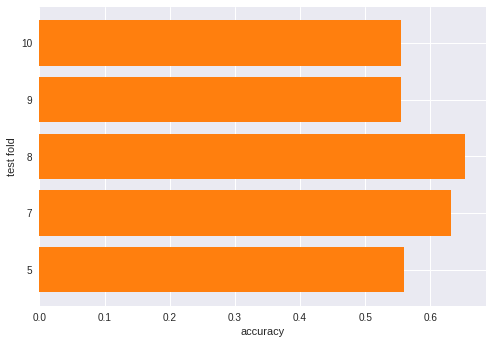

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_1hidden,X_test_per_fold,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnn1hidden_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.590641462802887
Std accuracy: 0.042462566955600155


### Two hidden-layer

In [ ]:
#two hidden-layer

ffnn_2hidden = Sequential()
ffnn_2hidden.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
ffnn_2hidden.add(layers.Dropout(0.25))
ffnn_2hidden.add(layers.Dense(24, activation='relu'))
ffnn_2hidden.add(layers.Dropout(0.25))
ffnn_2hidden.add(layers.Dense(num_class, activation='softmax'))
ffnn_2hidden.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_2hidden.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                1216      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_9 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                250       
Total params: 2,258
Trainable params: 2,258
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ffnn_2hidden.fit(X_train,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=1,
                    callbacks = [lr_decay_callback,early_stopping]
                    )

history_ffnn.append(history)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 7ms/step - loss: 1.7838 - accuracy: 0.3643 - val_loss: 1.7067 - val_accuracy: 0.5000
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.3765 - accuracy: 0.5230 - val_loss: 1.5352 - val_accuracy: 0.4766
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 3ms/step - loss: 1.1953 - accuracy: 0.5990 - val_loss: 1.4958 - val_accuracy: 0.5781
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 3ms/step - loss: 1.0945 - accuracy: 0.6241 - val_loss: 1.4198 - val_accuracy: 0.5781
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 3ms/step - loss: 1.0074 -

7/7 [==============================] - 0s 3ms/step - loss: 1.3658 - accuracy: 0.5974


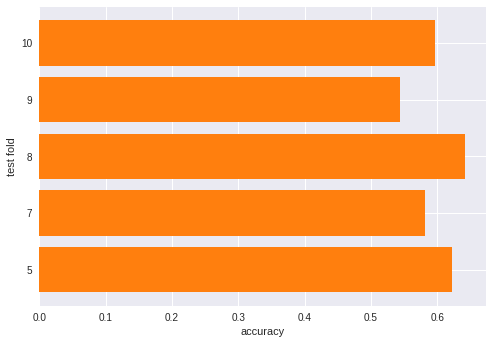

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_2hidden,X_test_per_fold,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnn2hidden_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.5971737742424011
Std accuracy: 0.033578335788689434


### Three hidden-layer

In [ ]:
#three hidden-layer

ffnn_3hidden = Sequential()
ffnn_3hidden.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
ffnn_3hidden.add(layers.Dropout(0.25))
ffnn_3hidden.add(layers.Dense(24, activation='relu'))
ffnn_3hidden.add(layers.Dropout(0.25))
ffnn_3hidden.add(layers.Dense(16, activation='relu'))
ffnn_3hidden.add(layers.Dropout(0.25))
ffnn_3hidden.add(layers.Dense(num_class, activation='softmax'))
ffnn_3hidden.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_3hidden.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                1216      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

In [ ]:
history = ffnn_3hidden.fit(X_train,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=1,
                    callbacks = [lr_decay_callback,early_stopping]
                    )

history_ffnn.append(history)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 7ms/step - loss: 2.1277 - accuracy: 0.2347 - val_loss: 1.9621 - val_accuracy: 0.2578
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.7201 - accuracy: 0.3950 - val_loss: 1.7585 - val_accuracy: 0.3984
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 3ms/step - loss: 1.4933 - accuracy: 0.4808 - val_loss: 1.6033 - val_accuracy: 0.4219
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 4ms/step - loss: 1.3576 - accuracy: 0.5375 - val_loss: 1.5936 - val_accuracy: 0.4375
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 4ms/step - loss: 1.2788 -

7/7 [==============================] - 0s 2ms/step - loss: 1.2841 - accuracy: 0.5878


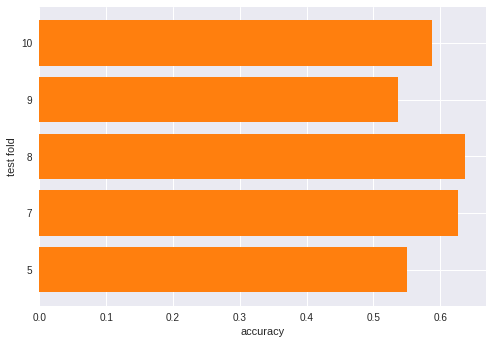

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_3hidden,X_test_per_fold,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnn3hidden_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.587552011013031
Std accuracy: 0.03970758990333674


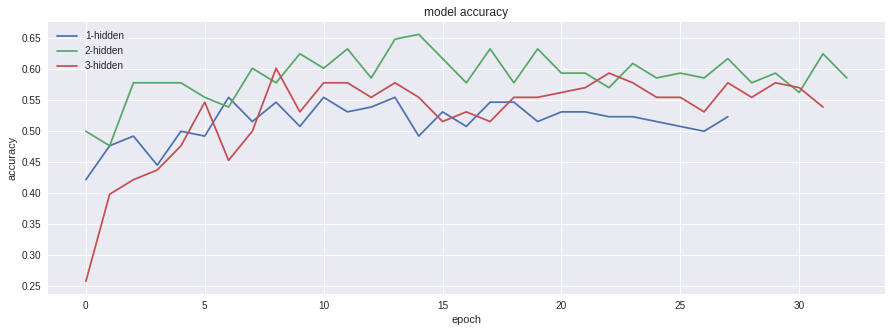

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,4):
    plt.plot(history_ffnn[i].history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(ffnn_labels[1:], loc='upper left')
plt.savefig('ffnn_val_acc.pdf')
plt.show()


### Dimensionality reduction

#### Boruta

In [ ]:
!pip install boruta

     |████████████████████████████████| 56 kB 2.6 MB/s 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

boruta_selector = BorutaPy(
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced', max_depth=5),
        n_estimators='auto',
        verbose=2,
        alpha=0.05, # p_value
        max_iter=100,
        random_state=42
)

boruta_result = boruta_selector.fit_transform(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	0


#### PCA

##### One for all

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#PCA them all!

X_train_pca = PCA(n_components=20).fit_transform(X_train)
validation_data_pca = (PCA(n_components=20).fit_transform(validation_data[0]),validation_data[1])
X_test_per_fold_pca = list(map(lambda X: PCA(n_components=20).fit_transform(X),X_test_per_fold))

In [ ]:
ffnn_pca = Sequential()
ffnn_pca.add(layers.Dense(32, activation='relu', input_shape=(X_train_pca.shape[1],)))
ffnn_pca.add(layers.Dropout(0.25))
ffnn_pca.add(layers.Dense(24, activation='relu'))
ffnn_pca.add(layers.Dropout(0.25))
ffnn_pca.add(layers.Dense(num_class, activation='softmax'))
ffnn_pca.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_pca.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_18 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                250       
Total params: 1,714
Trainable params: 1,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ffnn_pca.fit(X_train_pca,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data_pca,
                    validation_steps=1,
                    callbacks = [lr_decay_callback,early_stopping]
                    )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 6ms/step - loss: 1.8028 - accuracy: 0.3492 - val_loss: 2.1080 - val_accuracy: 0.1406
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.3499 - accuracy: 0.5295 - val_loss: 2.4752 - val_accuracy: 0.1562
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 3ms/step - loss: 1.2339 - accuracy: 0.5717 - val_loss: 2.5793 - val_accuracy: 0.1406
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 3ms/step - loss: 1.1301 - accuracy: 0.6068 - val_loss: 2.7311 - val_accuracy: 0.1172
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 3ms/step - loss: 1.0754 -

7/7 [==============================] - 0s 2ms/step - loss: 2.6071 - accuracy: 0.3011


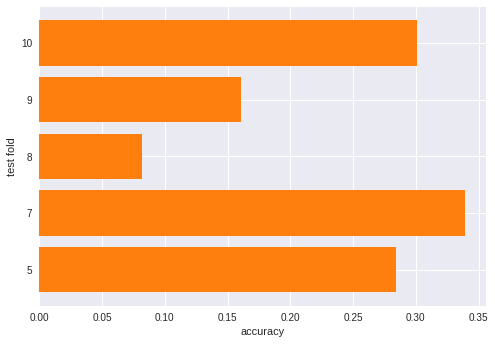

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_pca,X_test_per_fold_pca,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnnpca_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.23331810534000397
Std accuracy: 0.09649379922527322


##### Different PCAs for different features

In [ ]:
#One PCA for mfcc from 20 to 10
#One PCA for chroma from 12 to 5
#Concatenate mfcc, chroma, other features(zcr + rmse)

def pcaSchema(X,num_mfcc = 20, num_chroma = 12):
  X_mfcc = X[:,:num_mfcc]
  X_pca_mfcc = PCA(n_components=10).fit_transform(X_mfcc)
  X_chroma = X[:,num_mfcc:(num_mfcc + num_chroma)]
  X_chroma_pca = PCA(n_components=5).fit_transform(X_chroma)
  X_pcaSchema = np.hstack((X_pca_mfcc,X_chroma_pca,X[:,(num_mfcc+num_chroma):]))
  return X_pcaSchema

X_train_pcaSchema= pcaSchema(X_train)
validation_data_pcaSchema = (pcaSchema(validation_data[0]),validation_data[1])
X_test_per_fold_pcaSchema = list(map(lambda X: pcaSchema(X),X_test_per_fold))

In [ ]:
ffnn_pcaSchema = Sequential()
ffnn_pcaSchema.add(layers.Dense(32, activation='relu', input_shape=(X_train_pcaSchema.shape[1],)))
ffnn_pcaSchema.add(layers.Dropout(0.25))
ffnn_pcaSchema.add(layers.Dense(24, activation='relu'))
ffnn_pcaSchema.add(layers.Dropout(0.25))
ffnn_pcaSchema.add(layers.Dense(num_class, activation='softmax'))
ffnn_pcaSchema.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_pcaSchema.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_20 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                250       
Total params: 1,714
Trainable params: 1,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = ffnn_pcaSchema.fit(X_train_pcaSchema,
                    y_train,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data_pcaSchema,
                    validation_steps=1,
                    callbacks = [lr_decay_callback,early_stopping]
                    )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 6ms/step - loss: 1.9134 - accuracy: 0.3021 - val_loss: 1.8960 - val_accuracy: 0.3359
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.4206 - accuracy: 0.4883 - val_loss: 2.0569 - val_accuracy: 0.2109
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 2ms/step - loss: 1.2872 - accuracy: 0.5488 - val_loss: 2.1573 - val_accuracy: 0.2266
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 3ms/step - loss: 1.1924 - accuracy: 0.5870 - val_loss: 2.1719 - val_accuracy: 0.2188
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 3ms/step - loss: 1.1229 -

7/7 [==============================] - 0s 2ms/step - loss: 2.1829 - accuracy: 0.3931


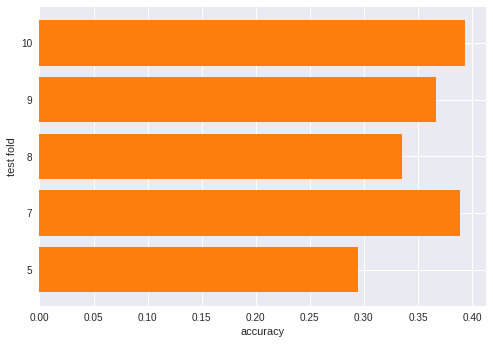

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(ffnn_pcaSchema,X_test_per_fold_pcaSchema,y_test_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('ffnnpcaSchema_acc_test_folds.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.35567458868026736
Std accuracy: 0.036744788230138804


## CNN

In [ ]:
import pandas as pd

dfsound = pd.read_csv(directory+'urbansound_features.csv')
dfsound.head()

,slice_file_name,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,zcr,rms_mean,rms_std,rms_min,rms_max,fold,classID
0,180937-7-0-1.wav,-138.33765,153.92632,-25.143291,23.735770,-9.101097,29.486742,-7.723937,17.950878,-3.847781,1.678083,9.908372,11.399974,-3.156736,4.597320,-1.361776,4.336464,2.165984,6.191244,-2.510937,-5.071014,0.737533,0.707738,0.733904,0.792608,0.744990,0.729957,0.762267,0.778216,0.850808,0.921533,0.911426,0.807324,0.045910,0.103949,0.031221,0.038049,0.203699,1,7
1,134717-0-0-23.wav,-256.36902,215.27115,4.275865,20.921730,-11.758430,10.720207,-9.677281,-8.810076,7.237295,-4.923639,-5.829611,-3.130413,-2.612591,-6.668170,-8.721065,-16.340954,-13.151767,-10.462835,-5.364130,-8.877783,0.601156,0.592372,0.576772,0.639420,0.716464,0.815491,0.891766,0.867365,0.763414,0.752363,0.689113,0.606438,0.018962,0.099550,0.038136,0.033675,0.289310,1,0
2,118101-3-0-4.wav,-612.10350,110.89383,-14.577455,-5.838351,-5.760063,-1.928239,-5.711015,0.441223,2.989164,6.006471,7.413587,6.518126,-1.555461,2.045586,1.495885,-3.814964,-4.097318,-0.939296,3.267052,0.023164,0.717998,0.690392,0.663172,0.655282,0.654024,0.643468,0.682281,0.806965,0.741230,0.702681,0.693658,0.700785,0.079283,0.003192,0.007044,0.000063,0.044778,1,3
3,108362-2-0-7.wav,-243.99520,175.44006,-45.750904,20.601976,-19.611889,-1.446711,-4.263446,10.769132,-3.902267,10.320066,-1.061575,-0.671871,2.627126,-0.983519,1.628523,0.266765,-1.226959,2.508085,6.218911,-0.226420,0.596894,0.609242,0.685194,0.625415,0.588624,0.642982,0.698439,0.674024,0.600234,0.593716,0.701617,0.701947,0.063680,0.041989,0.022702,0.014391,0.228666,1,2
4,103074-7-3-2.wav,-208.28404,127.58573,-41.217340,58.699917,-20.056097,15.070932,-6.990464,10.365518,-8.014215,14.499643,-4.234257,-2.803471,-10.144415,4.859932,-2.558723,8.407424,5.732546,3.859780,3.602500,-6.219582,0.956284,0.868329,0.805532,0.760023,0.682808,0.686549,0.659302,0.652517,0.605173,0.691882,0.831618,0.892438,0.093441,0.034151,0.008516,0.017339,0.078907,1,7


In [ ]:
#!unzip drive/MyDrive/UrbanSound/UrbanSound_img.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: UrbanSound8K/img_data/fold9/101729-0-0-1.png  
  inflating: UrbanSound8K/img_data/fold9/157866-8-0-2.png  
  inflating: UrbanSound8K/img_data/fold9/103249-5-0-6.png  
  inflating: UrbanSound8K/img_data/fold9/187075-5-0-5.png  
  inflating: UrbanSound8K/img_data/fold9/22885-5-0-0.png  
  inflating: UrbanSound8K/img_data/fold9/101729-0-0-24.png  
  inflating: UrbanSound8K/img_data/fold9/54976-4-1-0.png  
  inflating: UrbanSound8K/img_data/fold9/62567-5-0-0.png  
  inflating: UrbanSound8K/img_data/fold9/14111-4-0-6.png  
  inflating: UrbanSound8K/img_data/fold9/192123-2-0-22.png  
  inflating: UrbanSound8K/img_data/fold9/14527-9-0-7.png  
  inflating: UrbanSound8K/img_data/fold9/58937-4-0-13.png  
  inflating: UrbanSound8K/img_data/fold9/119809-7-0-6.png  
  inflating: UrbanSound8K/img_data/fold9/149929-9-1-0.png  
  inflating: UrbanSound8K/img_data/fold9/39532-4-3-0.png  
  inflating: UrbanSound8K/img_data/fold9/14385-9-0-17.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img

def getTFDataset(numFold,metadata):
    """
      Given the id of a certain fold and the metadata file,
      it returns the vectorial representation of the spectogram files in the fold along with their labels
    """
    pathFold = f'UrbanSound8K/img_data/fold{numFold}/'
    img = []
    labels = []

    for file in os.listdir(pathFold):
      if 'png' not in file: continue
      image_path = pathFold+file
      image = load_img(image_path,target_size=(64,64))
      x = img_to_array(image)
      filename = file.split('.')[0]
      wav = filename + '.wav'
      y = metadata[metadata['slice_file_name']==wav]['classID'].values[0]
      img.append(x)
      labels.append(y)
    
    return img,labels

In [ ]:
#Specgram train set construction
import numpy as np

train_img, train_labels = [],[]
for numFold in train_folds:
  img,labels = getTFDataset(numFold,dfsound)
  train_img  = train_img + img
  train_labels = train_labels + labels

train_img = np.asarray(train_img)
train_labels = np.asarray(train_labels)

In [ ]:
#Specgram test set construction
test_img_per_fold, test_labels_per_fold = [],[]

for numFold in test_folds:
  img,labels = getTFDataset(numFold,dfsound)
  test_img_per_fold.append(img)
  test_labels_per_fold.append(labels)

test_img_per_fold = list(map(lambda x: np.asarray(x),test_img_per_fold))
test_labels_per_fold = list(map(lambda x: np.asarray(x),test_labels_per_fold))

In [ ]:
validation_img = [e for f in test_img_per_fold for e in f]
validation_labels = [e for y in test_labels_per_fold for e in y]
validation_data_img = (np.asarray(validation_img),np.asarray(validation_labels))

In [ ]:
from keras.models import Sequential
from keras import layers

#ARCHITECTURES: 1 / 2 / 3 Conv2D Layers with 16 / 32 / 64 neurons + 32 / 64 / 128 Dense hidden neurons

num_conv2d_layers = [1,2,3]
num_conv2d_neurons = [16,32,64]
num_dense_neurons = [32,64,128]

cnns_labels = []
cnns = []

assert(len(num_conv2d_layers) == len(num_dense_neurons))

for num_layers in num_conv2d_layers:
  for num_dense in num_dense_neurons:
    cnns_labels.append(f'{num_layers}Conv2D_{num_dense}Dense')
    cnn = Sequential()
    cnn.add(layers.Rescaling(1./255,input_shape=(64,64,3)))
    for i in range(num_layers):
      cnn.add(layers.Conv2D(num_conv2d_neurons[i],3,padding='same',activation='relu'))
      cnn.add(layers.MaxPooling2D())
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(num_dense,activation='relu'))
    cnn.add(layers.Dense(10,activation='softmax'))
    cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    cnns.append(cnn)

history_cnn = []
for i in range(len(num_conv2d_layers)*len(num_dense_neurons)):
  print(f'{cnns_labels[i]} START')
  history = cnns[i].fit(train_img,
                    train_labels,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data = validation_data_img,
                    validation_steps = 1,
                    callbacks = [early_stopping]
                    )         
  print(f'{cnns_labels[i]} END')
  print()
  history_cnn.append(history)

1Conv2D_32Dense START
Epoch 1/100
36/36 [==============================] - 8s 219ms/step - loss: 2.4730 - accuracy: 0.1280 - val_loss: 2.2906 - val_accuracy: 0.1562
Epoch 2/100
36/36 [==============================] - 8s 209ms/step - loss: 2.2740 - accuracy: 0.1456 - val_loss: 2.2636 - val_accuracy: 0.1484
Epoch 3/100
36/36 [==============================] - 8s 211ms/step - loss: 2.2572 - accuracy: 0.1616 - val_loss: 2.2557 - val_accuracy: 0.1484
Epoch 4/100
36/36 [==============================] - 8s 209ms/step - loss: 2.2477 - accuracy: 0.1643 - val_loss: 2.2501 - val_accuracy: 0.1641
Epoch 5/100
36/36 [==============================] - 8s 209ms/step - loss: 2.2298 - accuracy: 0.1900 - val_loss: 2.2306 - val_accuracy: 0.1953
Epoch 6/100
36/36 [==============================] - 7s 208ms/step - loss: 2.2159 - accuracy: 0.1932 - val_loss: 2.2161 - val_accuracy: 0.1875
Epoch 7/100
36/36 [==============================] - 8s 211ms/step - loss: 2.2050 - accuracy: 0.1914 - val_loss: 2.2151 

7/7 [==============================] - 1s 91ms/step - loss: 2.0485 - accuracy: 0.2091


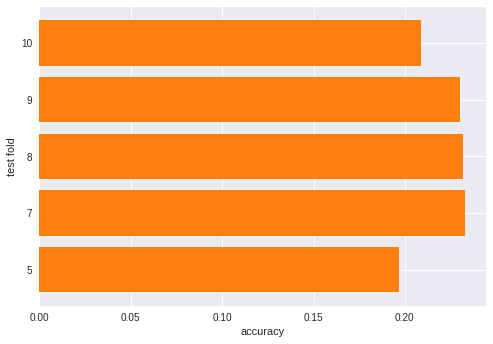

1Conv2D_32Dense
Avg accuracy: 0.22015204429626464
Std accuracy: 0.014703853883341032

7/7 [==============================] - 1s 83ms/step - loss: 2.0152 - accuracy: 0.2772


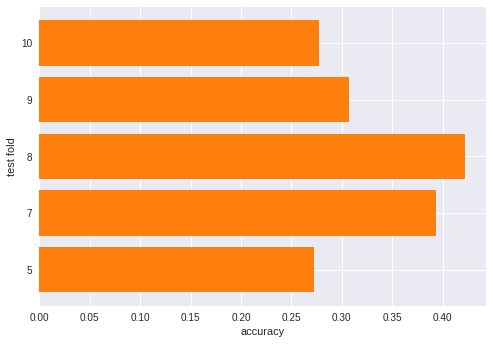

1Conv2D_64Dense
Avg accuracy: 0.33456906080245974
Std accuracy: 0.06165170562851118

7/7 [==============================] - 1s 91ms/step - loss: 2.1936 - accuracy: 0.4026


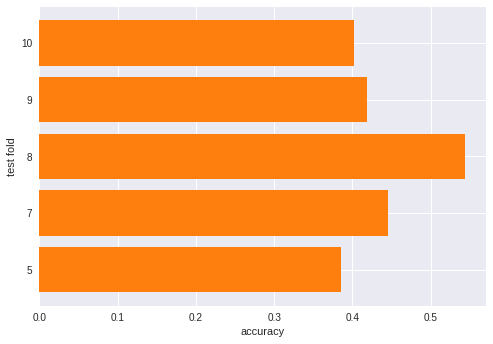

1Conv2D_128Dense
Avg accuracy: 0.4391923129558563
Std accuracy: 0.05568190120439265

7/7 [==============================] - 1s 116ms/step - loss: 2.8366 - accuracy: 0.4421


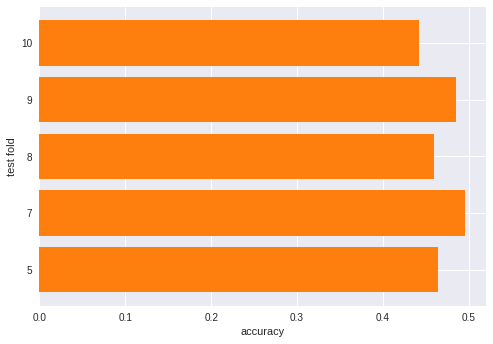

2Conv2D_32Dense
Avg accuracy: 0.46906161308288574
Std accuracy: 0.019008269700158266

7/7 [==============================] - 1s 116ms/step - loss: 2.3795 - accuracy: 0.4086


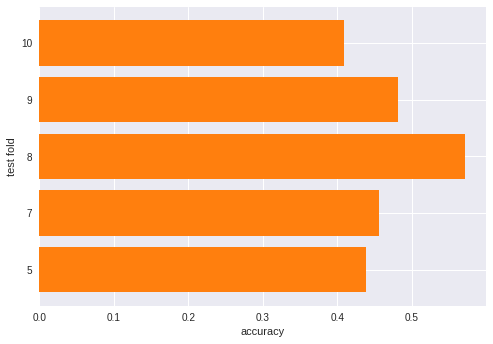

2Conv2D_64Dense
Avg accuracy: 0.4709641695022583
Std accuracy: 0.05525679987655807

7/7 [==============================] - 1s 120ms/step - loss: 3.0535 - accuracy: 0.4528


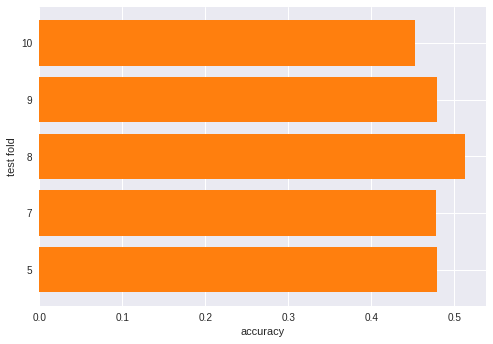

2Conv2D_128Dense
Avg accuracy: 0.4803067982196808
Std accuracy: 0.018941585702468962

7/7 [==============================] - 1s 142ms/step - loss: 2.4036 - accuracy: 0.4528


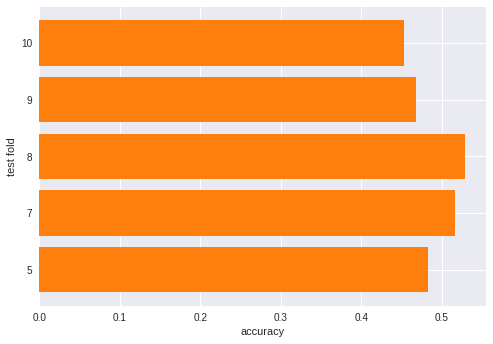

3Conv2D_32Dense
Avg accuracy: 0.48981866240501404
Std accuracy: 0.028669383002152406

7/7 [==============================] - 1s 144ms/step - loss: 3.2499 - accuracy: 0.4767


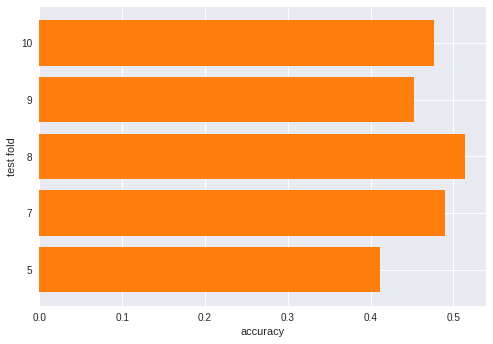

3Conv2D_64Dense
Avg accuracy: 0.46886685490608215
Std accuracy: 0.034989629794820454

7/7 [==============================] - 1s 144ms/step - loss: 3.1919 - accuracy: 0.4767


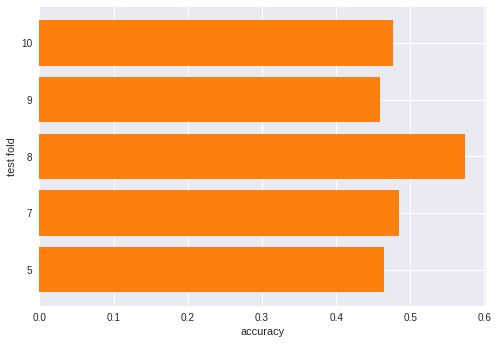

3Conv2D_128Dense
Avg accuracy: 0.49173855781555176
Std accuracy: 0.041663085838302104



In [ ]:
x = list(ITOFOLD.values())
for i in range(len(num_conv2d_layers)*len(num_dense_neurons)):
  accuracies = evaluate_on_test_folds(cnns[i],test_img_per_fold,test_labels_per_fold)
  plt.barh(x,accuracies,color='#ff7f0e')
  plt.xlabel('accuracy')
  plt.ylabel('test fold')
  plt.savefig(f'{cnns_labels[i]}.pdf',bbox_inches='tight')
  plt.show()
  print(f'{cnns_labels[i]}')
  print(f'Avg accuracy: {np.mean(accuracies)}')
  print(f'Std accuracy: {np.std(accuracies)}')
  print()

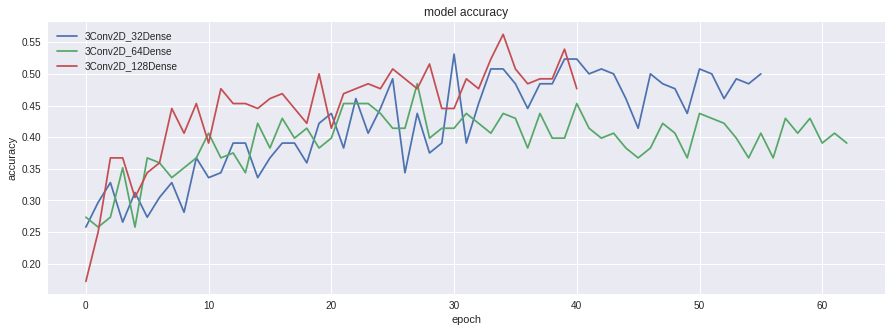

In [ ]:
plt.figure(figsize=(15,5))
for i in range(6,9):
    plt.plot(history_cnn[i].history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(cnns_labels[6:9], loc='upper left')
plt.savefig('CNN_3Conv2D_val_acc.pdf')
plt.show()

### Choose kernel size

KS = 1 start
Epoch 1/100
36/36 [==============================] - 8s 184ms/step - loss: 2.2102 - accuracy: 0.1565 - val_loss: 2.1761 - val_accuracy: 0.1328
Epoch 2/100
36/36 [==============================] - 6s 178ms/step - loss: 2.0575 - accuracy: 0.2243 - val_loss: 2.0483 - val_accuracy: 0.2422
Epoch 3/100
36/36 [==============================] - 6s 180ms/step - loss: 1.9659 - accuracy: 0.2736 - val_loss: 2.0118 - val_accuracy: 0.2891
Epoch 4/100
36/36 [==============================] - 7s 185ms/step - loss: 1.8924 - accuracy: 0.3001 - val_loss: 1.9642 - val_accuracy: 0.2578
Epoch 5/100
36/36 [==============================] - 7s 202ms/step - loss: 1.8143 - accuracy: 0.3221 - val_loss: 1.9206 - val_accuracy: 0.2578
Epoch 6/100
36/36 [==============================] - 7s 184ms/step - loss: 1.7620 - accuracy: 0.3412 - val_loss: 1.9280 - val_accuracy: 0.2188
Epoch 7/100
36/36 [==============================] - 7s 181ms/step - loss: 1.7211 - accuracy: 0.3687 - val_loss: 1.8955 - val_acc

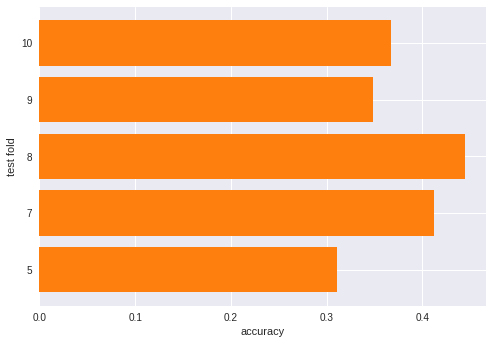

kernel-size: 1
Avg accuracy: 0.3763172090053558
Std accuracy: 0.04695873960970034

KS = 1 END

KS = 2 start
Epoch 1/100
36/36 [==============================] - 12s 329ms/step - loss: 2.2215 - accuracy: 0.1525 - val_loss: 2.1665 - val_accuracy: 0.2109
Epoch 2/100
36/36 [==============================] - 12s 323ms/step - loss: 2.0441 - accuracy: 0.2369 - val_loss: 2.0680 - val_accuracy: 0.2031
Epoch 3/100
36/36 [==============================] - 12s 322ms/step - loss: 1.9190 - accuracy: 0.2858 - val_loss: 1.9843 - val_accuracy: 0.2578
Epoch 4/100
36/36 [==============================] - 12s 323ms/step - loss: 1.8089 - accuracy: 0.3296 - val_loss: 1.9306 - val_accuracy: 0.2812
Epoch 5/100
36/36 [==============================] - 12s 323ms/step - loss: 1.7366 - accuracy: 0.3596 - val_loss: 1.8737 - val_accuracy: 0.2500
Epoch 6/100
36/36 [==============================] - 12s 324ms/step - loss: 1.6443 - accuracy: 0.4054 - val_loss: 1.8485 - val_accuracy: 0.3203
Epoch 7/100
36/36 [=========

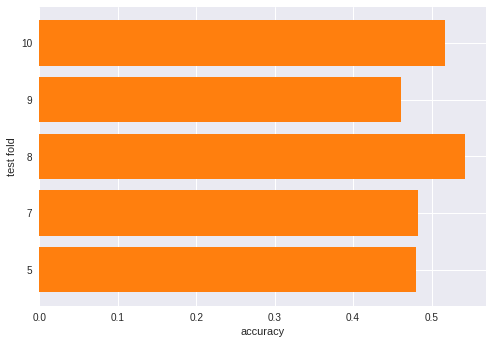

kernel-size: 2
Avg accuracy: 0.4966572344303131
Std accuracy: 0.02916413033504061

KS = 2 END

KS = 3 start
Epoch 1/100
36/36 [==============================] - 18s 484ms/step - loss: 2.1905 - accuracy: 0.1780 - val_loss: 2.1025 - val_accuracy: 0.1953
Epoch 2/100
36/36 [==============================] - 17s 480ms/step - loss: 1.9536 - accuracy: 0.2865 - val_loss: 1.9513 - val_accuracy: 0.2969
Epoch 3/100
36/36 [==============================] - 17s 484ms/step - loss: 1.8232 - accuracy: 0.3216 - val_loss: 1.9564 - val_accuracy: 0.2422
Epoch 4/100
36/36 [==============================] - 17s 482ms/step - loss: 1.7295 - accuracy: 0.3685 - val_loss: 1.9703 - val_accuracy: 0.2188
Epoch 5/100
36/36 [==============================] - 17s 484ms/step - loss: 1.5912 - accuracy: 0.4259 - val_loss: 1.8351 - val_accuracy: 0.2734
Epoch 6/100
36/36 [==============================] - 17s 482ms/step - loss: 1.4726 - accuracy: 0.4677 - val_loss: 1.7782 - val_accuracy: 0.3359
Epoch 7/100
36/36 [=========

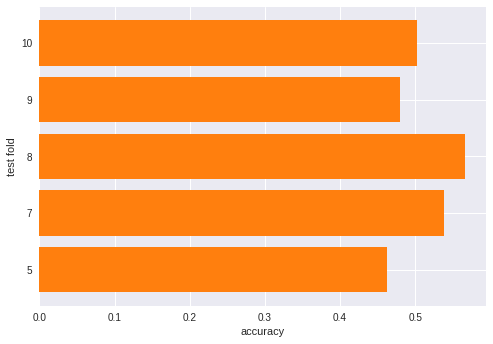

kernel-size: 3
Avg accuracy: 0.509501713514328
Std accuracy: 0.03785818856026423

KS = 3 END

KS = 4 start
Epoch 1/100
36/36 [==============================] - 25s 692ms/step - loss: 2.1896 - accuracy: 0.1838 - val_loss: 2.0706 - val_accuracy: 0.2422
Epoch 2/100
36/36 [==============================] - 25s 685ms/step - loss: 1.9530 - accuracy: 0.2743 - val_loss: 2.0240 - val_accuracy: 0.2109
Epoch 3/100
36/36 [==============================] - 25s 686ms/step - loss: 1.8176 - accuracy: 0.3221 - val_loss: 1.9223 - val_accuracy: 0.2812
Epoch 4/100
36/36 [==============================] - 25s 685ms/step - loss: 1.7052 - accuracy: 0.3694 - val_loss: 1.8691 - val_accuracy: 0.3281
Epoch 5/100
36/36 [==============================] - 25s 688ms/step - loss: 1.5682 - accuracy: 0.4225 - val_loss: 1.9814 - val_accuracy: 0.2344
Epoch 6/100
36/36 [==============================] - 25s 685ms/step - loss: 1.4685 - accuracy: 0.4714 - val_loss: 1.9228 - val_accuracy: 0.2500
Epoch 7/100
36/36 [==========

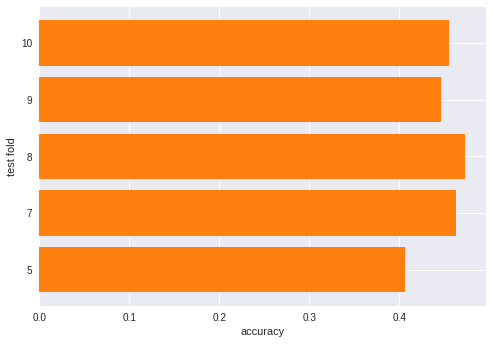

kernel-size: 4
Avg accuracy: 0.4485940635204315
Std accuracy: 0.023042133102907692

KS = 4 END

KS = 5 start
Epoch 1/100
36/36 [==============================] - 35s 966ms/step - loss: 2.1459 - accuracy: 0.1852 - val_loss: 2.0701 - val_accuracy: 0.1719
Epoch 2/100
36/36 [==============================] - 35s 961ms/step - loss: 1.9086 - accuracy: 0.3065 - val_loss: 2.0219 - val_accuracy: 0.2188
Epoch 3/100
36/36 [==============================] - 35s 964ms/step - loss: 1.7178 - accuracy: 0.3747 - val_loss: 1.9978 - val_accuracy: 0.2812
Epoch 4/100
36/36 [==============================] - 35s 960ms/step - loss: 1.6087 - accuracy: 0.4179 - val_loss: 1.8802 - val_accuracy: 0.3359
Epoch 5/100
36/36 [==============================] - 35s 960ms/step - loss: 1.5295 - accuracy: 0.4454 - val_loss: 1.8785 - val_accuracy: 0.3047
Epoch 6/100
36/36 [==============================] - 35s 965ms/step - loss: 1.3930 - accuracy: 0.4950 - val_loss: 1.9028 - val_accuracy: 0.3047
Epoch 7/100
36/36 [========

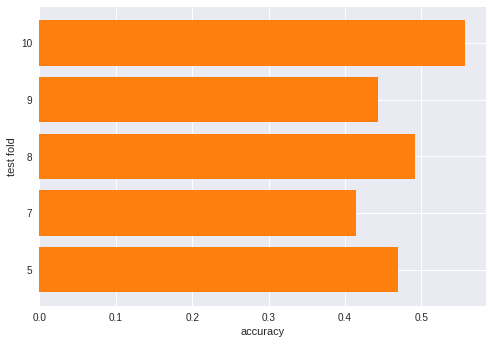

kernel-size: 5
Avg accuracy: 0.4751718997955322
Std accuracy: 0.04830867820603076

KS = 5 END



In [ ]:
x = list(ITOFOLD.values())
acc_ks = []
for ks in range(1,6): #grid search on kernel size in range [1,5]
  print(f'KS = {ks} start')
  cnn = Sequential()
  cnn.add(layers.Rescaling(1./255,input_shape=(64,64,3)))
  cnn.add(layers.Conv2D(16,ks,padding='same',activation='relu'))
  cnn.add(layers.MaxPooling2D())
  cnn.add(layers.Conv2D(32,ks,padding='same',activation='relu'))
  cnn.add(layers.MaxPooling2D())
  cnn.add(layers.Conv2D(64,ks,padding='same',activation='relu'))
  cnn.add(layers.MaxPooling2D())
  cnn.add(layers.Flatten())
  cnn.add(layers.Dense(128,activation='relu'))
  cnn.add(layers.Dense(10,activation='softmax'))

  cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  history = cnn.fit(train_img,
                    train_labels,
                    epochs=NUM_EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data = validation_data_img,
                    validation_steps = 1,
                    callbacks = [early_stopping]
                    )
  
  accuracies = evaluate_on_test_folds(cnn,test_img_per_fold,test_labels_per_fold)
  plt.barh(x,accuracies,color='#ff7f0e')
  plt.xlabel('accuracy')
  plt.ylabel('test fold')
  plt.savefig(f'cnn_ks{ks}.pdf',bbox_inches='tight')
  plt.show()
  print(f'kernel-size: {ks}')
  print(f'Avg accuracy: {np.mean(accuracies)}')
  print(f'Std accuracy: {np.std(accuracies)}')
  acc_ks.append(np.mean(accuracies))
  print()
  print(f'KS = {ks} END')
  print()

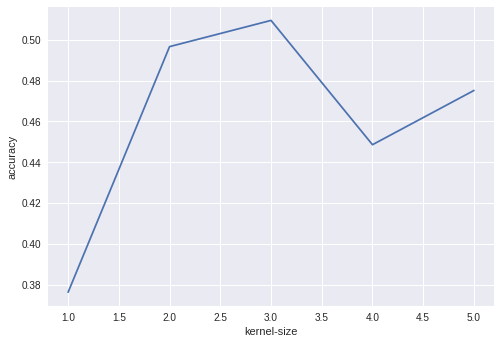

In [ ]:
plt.plot(range(1,6),acc_ks)
plt.xlabel('kernel-size')
plt.ylabel('accuracy')
plt.savefig('CNN_kernel-size_acc.pdf',bbox_inches='tight')
plt.show()

## MMNN

In [ ]:
from tensorflow.keras import Model

#FFNN

input_ffnn =  layers.Input(shape=(X_train.shape[1]), name="features_data")
hidden = layers.Dense(32,activation='relu')(input_ffnn)
dropout = layers.Dropout(0.25)(hidden)
hidden = layers.Dense(24, activation='relu')(dropout)
dropout = layers.Dropout(0.25)(hidden)
last_hidden_ffnn = dropout


#CNN

input_cnn = layers.Input(shape=(64,64,3), name = 'specgram_data')
rescaling = layers.Rescaling(1./255)(input_cnn)
conv2d = layers.Conv2D(16,3,padding='same',activation='relu')(rescaling)
pooling = layers.MaxPooling2D()(conv2d)
conv2d = layers.Conv2D(32,3,padding='same',activation='relu')(pooling)
pooling = layers.MaxPooling2D()(conv2d)
conv2d = layers.Conv2D(64,3,padding='same',activation='relu')(pooling)
pooling = layers.MaxPooling2D()(conv2d)
flatten = layers.Flatten()(pooling)
last_hidden_cnn = layers.Dense(128,activation='relu')(flatten)

#MMNN
concatenate = layers.Concatenate()([last_hidden_ffnn,last_hidden_cnn])
last_hidden_mmnn = layers.Dense(64,activation='relu')(concatenate)
output_mmnn = layers.Dense(10,activation='softmax')(last_hidden_mmnn)

mmnn = Model(
  inputs=[input_ffnn, input_cnn],
  outputs=output_mmnn,
  name="MMNN"
)

mmnn.compile(
  optimizer="adam",
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy']
)



mmnn.summary()

Model: "MMNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
specgram_data (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           specgram_data[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         rescaling[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           conv2d[0][0]                     
_______________________________________________________________________________________________

In [ ]:
X_mmnn = {
    'features_data': X_train,
    'specgram_data': train_img
}

y_mmnn = y_train

validation_mmnn = ({
    'features_data': validation_data[0],
    'specgram_data': validation_data_img[0]
}, validation_data[1])

In [ ]:
history = mmnn.fit(X_mmnn,
                    y_mmnn,
                    epochs=40,
                    batch_size=BATCH_SIZE,
                    validation_data = validation_mmnn,
                    validation_steps = 1,
                    callbacks = []
                    )         

Epoch 1/40
36/36 [==============================] - 19s 492ms/step - loss: 2.1361 - accuracy: 0.2072 - val_loss: 2.0477 - val_accuracy: 0.2109
Epoch 2/40
36/36 [==============================] - 18s 486ms/step - loss: 1.8631 - accuracy: 0.3263 - val_loss: 1.8411 - val_accuracy: 0.3125
Epoch 3/40
36/36 [==============================] - 18s 495ms/step - loss: 1.6661 - accuracy: 0.3956 - val_loss: 1.8197 - val_accuracy: 0.3438
Epoch 4/40
36/36 [==============================] - 18s 486ms/step - loss: 1.5367 - accuracy: 0.4592 - val_loss: 1.7284 - val_accuracy: 0.3750
Epoch 5/40
36/36 [==============================] - 17s 486ms/step - loss: 1.4505 - accuracy: 0.4834 - val_loss: 1.7029 - val_accuracy: 0.3906
Epoch 6/40
36/36 [==============================] - 17s 485ms/step - loss: 1.3834 - accuracy: 0.5008 - val_loss: 1.6723 - val_accuracy: 0.4609
Epoch 7/40
36/36 [==============================] - 17s 480ms/step - loss: 1.3227 - accuracy: 0.5312 - val_loss: 1.6351 - val_accuracy: 0.4531

In [ ]:
test_mmnn_per_fold = []
labels_mmnn_per_fold = []
for xf,xs,y in zip(X_test_per_fold,test_img_per_fold,y_test_per_fold):
  test_mmnn_per_fold.append(
      {
      'features_data': xf,
      'specgram_data': xs
  })
  labels_mmnn_per_fold.append(y)

7/7 [==============================] - 1s 132ms/step - loss: 1.3422 - accuracy: 0.5484


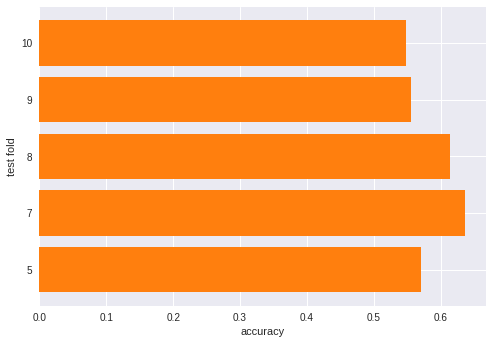

In [ ]:
x = list(ITOFOLD.values())
accuracies = evaluate_on_test_folds(mmnn,test_mmnn_per_fold,labels_mmnn_per_fold)
plt.barh(x,accuracies,color='#ff7f0e')
plt.xlabel('accuracy')
plt.ylabel('test fold')
plt.savefig('mmnn_acc.pdf',bbox_inches='tight')
plt.show()

In [ ]:
print(f'Avg accuracy: {np.mean(accuracies)}')
print(f'Std accuracy: {np.std(accuracies)}')

Avg accuracy: 0.5848458170890808
Std accuracy: 0.034338680895334296


In [ ]:
ffnn_2hidden = Sequential()
ffnn_2hidden.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
ffnn_2hidden.add(layers.Dropout(0.25))
ffnn_2hidden.add(layers.Dense(24, activation='relu'))
ffnn_2hidden.add(layers.Dropout(0.25))
ffnn_2hidden.add(layers.Dense(num_class, activation='softmax'))
ffnn_2hidden.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ffnn_2hidden.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 32)                1216      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_16 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                250       
Total params: 2,258
Trainable params: 2,258
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2hidden = ffnn_2hidden.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_data,
                    validation_steps=1,
                    callbacks = [lr_decay_callback]
                    )

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
36/36 [==============================] - 1s 7ms/step - loss: 1.7816 - accuracy: 0.3783 - val_loss: 1.5598 - val_accuracy: 0.4375
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
36/36 [==============================] - 0s 3ms/step - loss: 1.3411 - accuracy: 0.5319 - val_loss: 1.5516 - val_accuracy: 0.4375
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
36/36 [==============================] - 0s 3ms/step - loss: 1.1554 - accuracy: 0.6092 - val_loss: 1.5422 - val_accuracy: 0.4375
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
36/36 [==============================] - 0s 2ms/step - loss: 1.0510 - accuracy: 0.6404 - val_loss: 1.5834 - val_accuracy: 0.4609
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
36/36 [==============================] - 0s 3ms/step - loss: 0.9798 - accu

In [ ]:
best_cnn = Sequential()
best_cnn.add(layers.Rescaling(1./255,input_shape=(64,64,3)))
best_cnn.add(layers.Conv2D(16,3,padding='same',activation='relu'))
best_cnn.add(layers.MaxPooling2D())
best_cnn.add(layers.Conv2D(32,3,padding='same',activation='relu'))
best_cnn.add(layers.MaxPooling2D())
best_cnn.add(layers.Conv2D(64,3,padding='same',activation='relu'))
best_cnn.add(layers.MaxPooling2D())
best_cnn.add(layers.Flatten())
best_cnn.add(layers.Dense(128,activation='relu'))
best_cnn.add(layers.Dense(10,activation='softmax'))

best_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
history_bestcnn = best_cnn.fit(train_img,
                    train_labels,
                    epochs=40,
                    batch_size=BATCH_SIZE,
                    validation_data = validation_data_img,
                    validation_steps = 1,
                    callbacks = []
                    )

Epoch 1/40
36/36 [==============================] - 18s 496ms/step - loss: 2.1571 - accuracy: 0.1769 - val_loss: 2.2091 - val_accuracy: 0.1719
Epoch 2/40
36/36 [==============================] - 18s 489ms/step - loss: 1.9334 - accuracy: 0.2852 - val_loss: 2.0378 - val_accuracy: 0.2656
Epoch 3/40
36/36 [==============================] - 18s 489ms/step - loss: 1.7830 - accuracy: 0.3367 - val_loss: 1.9308 - val_accuracy: 0.2812
Epoch 4/40
36/36 [==============================] - 18s 492ms/step - loss: 1.6568 - accuracy: 0.3905 - val_loss: 1.8676 - val_accuracy: 0.3281
Epoch 5/40
36/36 [==============================] - 18s 487ms/step - loss: 1.5254 - accuracy: 0.4512 - val_loss: 1.9618 - val_accuracy: 0.2500
Epoch 6/40
36/36 [==============================] - 17s 486ms/step - loss: 1.4062 - accuracy: 0.4974 - val_loss: 1.7868 - val_accuracy: 0.3203
Epoch 7/40
36/36 [==============================] - 17s 486ms/step - loss: 1.2622 - accuracy: 0.5499 - val_loss: 1.8752 - val_accuracy: 0.3750

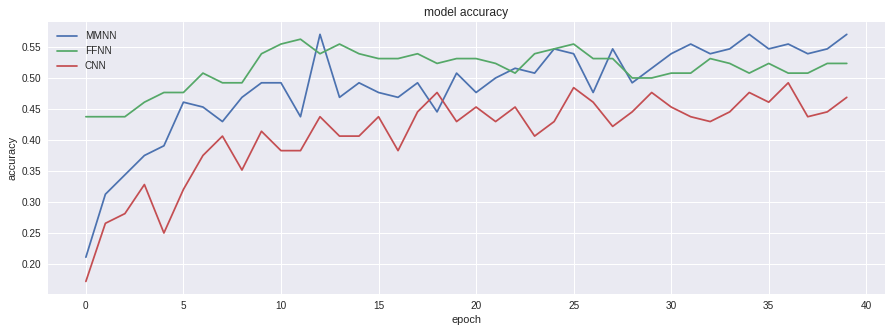

In [ ]:
nnlabels = ['MMNN','FFNN','CNN']
plt.figure(figsize=(15,5))
for h in [history,history2hidden,history_bestcnn]:
    plt.plot(h.history['val_accuracy'])  
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(nnlabels, loc='upper left')
plt.savefig('best_nn_acc.pdf',bbox_inches='tight')
plt.show()